In [1]:
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp, Statevector

from qiskit_aer import AerSimulator

from qiskit_ibm_runtime.fake_provider import FakeValenciaV2
from qiskit_ibm_runtime import EstimatorV2, SamplerV2

from qiskit_addon_cutting import cut_gates, generate_cutting_experiments, reconstruct_expectation_values

import matplotlib.pyplot as plt
import numpy as np

from utils import export_data_json, generate_output_dir, generate_full_file_path

In [2]:
OUTPUT_PATH = os.path.join(os.getcwd(), 'circuit-knitting-tests')
generate_output_dir(OUTPUT_PATH)

/home/alexandre/projects/scientific-research-2-qec-and-qem/src/circuit-knitting-tests already exists!


In [3]:
fake_backend = FakeValenciaV2()
backend = AerSimulator.from_backend(fake_backend)
estimator = EstimatorV2(backend=backend)
sampler = SamplerV2(backend=backend)
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

In [4]:
N_QUBITS=3

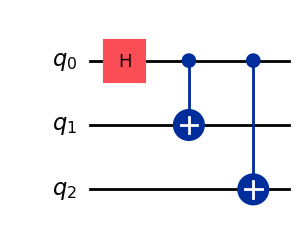

<IPython.core.display.Latex object>

Circuit Depth: 3


In [5]:
qc = QuantumCircuit(N_QUBITS)
qc.h(0)
qc.cx(0,1)
qc.cx(0,2)
display(qc.draw('mpl', filename=generate_full_file_path(OUTPUT_PATH, "GHZ-circuit.png")))
display(Statevector(qc).draw('latex'))
print(f"Circuit Depth: {qc.depth()}")


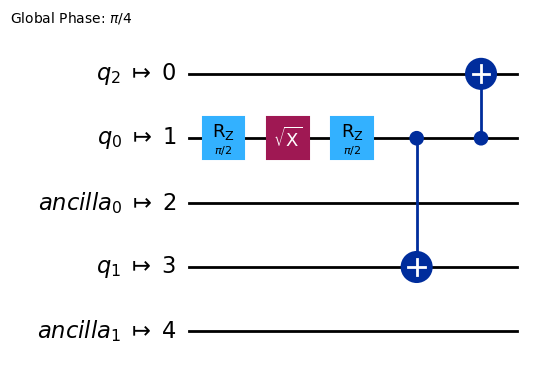

ISA Circuit Depth: 5


In [6]:
isa_qc = pm.run(qc)
display(isa_qc.draw('mpl', filename=generate_full_file_path(OUTPUT_PATH, "ISA-GHZ-circuit.png")))
print(f"ISA Circuit Depth: {isa_qc.depth()}")

In [7]:
obs = SparsePauliOp(['IZIZZ']) # it'll depends on what ISA circuit PM gave you
estimator.run([(isa_qc, obs)]).result()[0].data.evs

array(0.00244141)

In [8]:
p_obs = obs.to_matrix()

state = np.zeros((2**5,1))
state[0] = 1/np.sqrt(2)
state[-1] = 1/np.sqrt(2)
state = np.asmatrix(state)

(state.H @ p_obs) @ state

matrix([[0.+0.j]])

In [9]:
cut_indices = [2]
qpd_circuit, bases = cut_gates(qc, cut_indices)

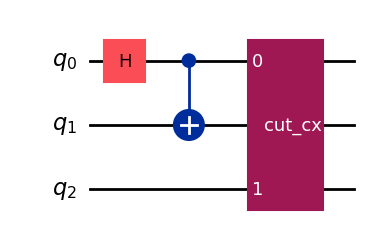

In [10]:
display(qpd_circuit.draw('mpl', filename=generate_full_file_path(OUTPUT_PATH, "Cut-GHZ-circuit.png")))

In [11]:
obs = SparsePauliOp(['ZZZ'])

In [12]:
subexperiments, coefficients = generate_cutting_experiments(
    circuits=qpd_circuit, observables=obs.paulis, num_samples=np.inf
)

In [13]:
isa_subexperiments = pm.run(subexperiments)

In [14]:
results = sampler.run(isa_subexperiments).result()

In [15]:
reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    obs.paulis,
)
np.dot(reconstructed_expval_terms, obs.coeffs)

(0.0166015625+0j)